In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1. Análise Exploratória

### Valor total vendido e Valor total da meta por ano?

In [55]:
# Pegar todas os arquivos Vendas.xlsx
all_filenames = os.listdir('../archives/vendas/')

# Combinando todos os arquivos Vendas.xlsx em um único dataframe
sales_dataframe = pd.concat([pd.read_excel(f'../archives/vendas/{b}') for b in all_filenames])

dates_dataframe = pd.read_excel('../archives/Dimensões.xlsx', sheet_name='Data')

In [56]:
goals_dataframe = pd.read_excel('../archives/base-meta-new.xlsx')

goals_dataframe = goals_dataframe.iloc[3:,1:]

In [57]:
sales_dataframe

,DataEmissao,DataVencimento,NFe,cdCliente,cdVendedor,cdProduto,QtdItens,ValorUnitario,Peso Líquido
0,2017-01-12,2017-02-22,1492762,3140218,265,1073,6,8.83,0.60
1,2017-01-12,2017-02-22,1492762,3140218,265,1420,6,4.44,5.40
2,2017-01-12,2017-02-22,1492762,3140218,265,264,10,0.96,1.92
3,2017-01-13,2017-01-29,1492719,2983332,265,1154,6,2.92,1.26
4,2017-01-13,2017-01-29,1492719,2983332,265,1527,6,2.81,1.40
...,...,...,...,...,...,...,...,...,...
14243,2022-03-12,2022-04-14,2173547,673190,265,202,24,1.62,1.50
14244,2022-03-12,2022-04-14,2173547,673190,265,1154,12,3.25,1.75
14245,2022-03-12,2022-04-14,2173547,673190,265,668,12,3.26,1.00
14246,2022-03-12,2022-04-14,2173547,673190,265,1527,12,3.14,1.00


In [58]:
# Unindo o dataframe de vendas com as datas e anos
sales_date_merged_dataframe = pd.merge(
    sales_dataframe[['DataEmissao', 'QtdItens', 'ValorUnitario', 'Peso Líquido']], 
    dates_dataframe[['Data', 'MesNum', 'Ano', 'Mes']], 
    left_on='DataEmissao', 
    right_on='Data'
)

# Atribuindo uma nova coluna - Valor Total
sales_date_merged_dataframe['ValorTotal'] = sales_date_merged_dataframe['QtdItens'] * sales_date_merged_dataframe['ValorUnitario']

# Dataframe contendo o total de vendas por ano
sales_per_year_dataframe = sales_date_merged_dataframe[['MesNum', 'Ano', 'ValorTotal', 'QtdItens', 'Peso Líquido']].groupby(by='Ano').agg('sum').reset_index()

In [59]:
goals_dataframe.columns = [
    'cdVendedor',
    'Data',
    'Meta'
]

goals_dataframe['Data'] = goals_dataframe['Data'].astype('datetime64[ns]')

sales_dates_and_targets = pd.merge(
    sales_date_merged_dataframe,
    goals_dataframe,
    left_on='DataEmissao',
    right_on='Data'
)

sales_per_year_and_targets_dataframe = sales_dates_and_targets[['Ano', 'ValorTotal', 'Meta']].groupby(by='Ano').sum().reset_index()

In [60]:
sales_per_year_and_targets_dataframe

,Ano,ValorTotal,Meta
0,2017,2200840.62,2900051901.253603
1,2018,3320970.51,4988886141.973967
2,2019,403931.99,651002813


### Crie um gráfico de linhas para exibir o comportamento das vendas ao longo do ano de 2021.

In [61]:
sales_in_2019_dataframe = sales_date_merged_dataframe[sales_date_merged_dataframe['Ano'] == 2018]

sales_in_2019_dataframe = sales_in_2019_dataframe[['MesNum', 'Mes', 'ValorTotal']].groupby(by=['Mes', 'MesNum']).sum().sort_values(by='MesNum').reset_index()

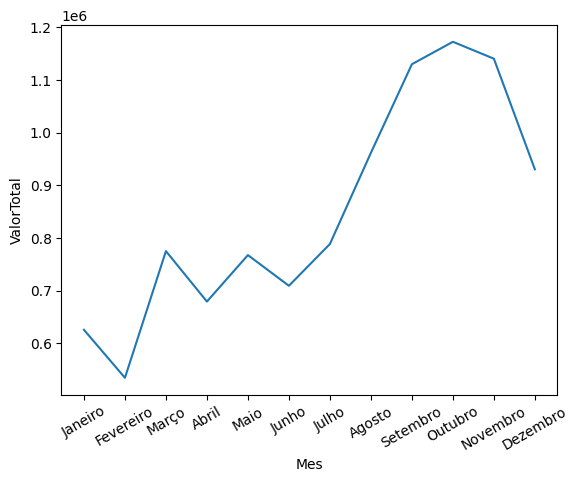

In [62]:
sns.lineplot(data=sales_in_2019_dataframe , x="Mes", y="ValorTotal")

plt.xticks(sales_in_2019_dataframe['Mes'])

plt.xticks(rotation=30)

plt.show()

### Quantos clientes ativos e inativos temos em nossa empresa?

In [63]:
# Carregando o dataframe de clientes
customer_dataframe = pd.read_excel('../archives/Dimensões.xlsx', sheet_name='Cliente')

In [64]:
# Separando a quantidade de clientes ativos e inativos
actives, inactives = customer_dataframe['Status'].value_counts()

print(f"-> Total de clientes ativos: {actives}")
print(f"-> Total de clientes inativos: {inactives}")

-> Total de clientes ativos: 1364
-> Total de clientes inativos: 47


### Qual a linha de produtos mais vendida?

In [65]:
product_dataframe = pd.read_excel('../archives/Dimensões.xlsx', 'Produto')
group_product_dataframe = pd.read_excel('../archives/Dimensões.xlsx', 'GrupoProduto')

In [66]:
products_lines = pd.merge(
    product_dataframe,
    group_product_dataframe,
    left_on='cdGrupo',
    right_on='cdGrupo'
)

sales_with_products_lines_merged = pd.merge(
    products_lines,
    sales_dataframe[['cdProduto', 'QtdItens', 'ValorUnitario']],
    left_on='cdProduto',
    right_on='cdProduto'
)

In [67]:
sales_with_products_lines = sales_with_products_lines_merged[['Linha', 'QtdItens']].groupby(by='Linha').sum().reset_index()

In [68]:
sales_with_products_lines['TotalVendido'] = sales_with_products_lines['QtdItens'] * sales_with_products_lines_merged['ValorUnitario']

In [69]:
sales_with_products_lines

,Linha,QtdItens,TotalVendido
0,Alimentos,7265872,56528484.16
1,Bebidas,162267,1270550.61


### Qual foi a quantidade total de produtos vendidos por ano?

In [70]:
number_products_sold_per_year = sales_per_year_dataframe.drop(columns=['MesNum', 'ValorTotal', 'Peso Líquido'])

number_products_sold_per_year

,Ano,QtdItens
0,2017,2167345
1,2018,3864838
2,2019,348989


### Qual foi o total de peso em toneladas dos produtos vendidos em todo o período?

In [71]:
sales_per_year_dataframe

,Ano,MesNum,ValorTotal,QtdItens,Peso Líquido
0,2017,718818,6648222.05,2167345,414819.40
1,2018,1143833,10214809.43,3864838,658505.01
2,2019,19402,1046201.01,348989,61465.62


In [72]:
total_weight = sales_per_year_dataframe['Peso Líquido'].sum()

print(f"Peso total, em todo o período: {total_weight:,.0f}t")

Peso total, em todo o período: 1,134,790t
